![alt text](awesome_logo.png "Awesome Retirement Portfolio Projector Tool")

# My Portfolio

In [2]:
import sqlalchemy as sql
import pandas as pd
import os
import datetime
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv

load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [3]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [4]:
# Get porfolio data
connection_string = 'sqlite:///awesome_app.db'
engine = sql.create_engine(connection_string, echo=False)

sql = """
  SELECT *
  FROM portfolio
"""

portfolio_df = pd.read_sql_query(sql, engine)
portfolio_df

,symbol,quantity,type
0,TSLA,5000.0,Equity
1,COIN,500.0,Equity


In [5]:
# Set the tickers
tickers = portfolio_df["symbol"]
# Set timeframe to one day ('1D') for the Alpaca API
timeframe = "1D"
# Set the number of years of data to fetch
num_years = 30

batch_size = 1000
num_days_data_needed = num_years * 365
first_date = datetime.datetime.now()
last_date = first_date - datetime.timedelta(days=num_days_data_needed)

def format_date_iso(date):
    return pd.Timestamp(date, tz="America/New_York").isoformat()

all_results_df = pd.DataFrame()
next_batch_date = first_date

while num_days_data_needed > 0:
    end_date = str(next_batch_date).split()[0]
    
    next_batch_date -= datetime.timedelta(days=batch_size)
    if next_batch_date < last_date:
        next_batch_date = last_date

    start_date = str(next_batch_date).split()[0]
    
    results_batch_df = alpaca.get_barset(
        tickers,
        timeframe,
        start = format_date_iso(start_date),
        end = format_date_iso(end_date),
        limit = batch_size
    ).df

    all_results_df = pd.concat([all_results_df, results_batch_df])
    num_days_data_needed -= batch_size
    
all_results_df.sort_index(inplace=True)

# Display data
all_results_df

COIN                                        \
                             open    high       low   close      volume   
time                                                                      
2010-06-29 04:00:00+00:00     NaN     NaN       NaN     NaN         NaN   
2010-06-30 04:00:00+00:00     NaN     NaN       NaN     NaN         NaN   
2010-07-01 04:00:00+00:00     NaN     NaN       NaN     NaN         NaN   
2010-07-02 04:00:00+00:00     NaN     NaN       NaN     NaN         NaN   
2010-07-06 04:00:00+00:00     NaN     NaN       NaN     NaN         NaN   
...                           ...     ...       ...     ...         ...   
2021-08-09 00:00:00-04:00  267.30  282.43  267.3000  280.54   8496076.0   
2021-08-10 00:00:00-04:00  280.75  281.50  264.2500  269.30   6134098.0   
2021-08-11 00:00:00-04:00  282.50  294.00  274.3501  278.41  13382381.0   
2021-08-12 00:00:00-04:00  266.55  267.75  255.2000  256.40   7993497.0   
2021-08-13 00:00:00-04:00  262.80  266.50  259.9700  261.30   4128420.0   

                             TSLA                                        
                             open      high     low     close    volume  
time                                                                     
2010-06-29 04:00:00+00:00   19.00   25.0000   17.54   23.9400  18586286  
2010-06-30 04:00:00+00:00   25.88   30.4192   23.30   23.6300  16740222  
2010-07-01 04:00:00+00:00   25.00   25.9200   20.27   21.9000   8045449  
2010-07-02 04:00:00+00:00   23.00   23.1000   18.71   19.2000   4977765  
2010-07-06 04:00:00+00:00   20.00   20.0000   15.83   15.9800   6640566  
...                           ...       ...     ...       ...       ...  
2021-08-09 00:00:00-04:00  710.01  719.0300  705.13  713.7300  13158590  
2021-08-10 00:00:00-04:00  713.25  716.5900  701.88  709.9900  12217890  
2021-08-11 00:00:00-04:00  712.75  715.1800  704.21  707.8400   9070550  
2021-08-12 00:00:00-04:00  706.37  722.8000  699.40  722.1983  16743143  
2021-08-13 00:00:00-04:00  723.80  729.9000  714.34  717.2800  15123022  

[2803 rows x 10 columns]

<AxesSubplot:xlabel='time'>

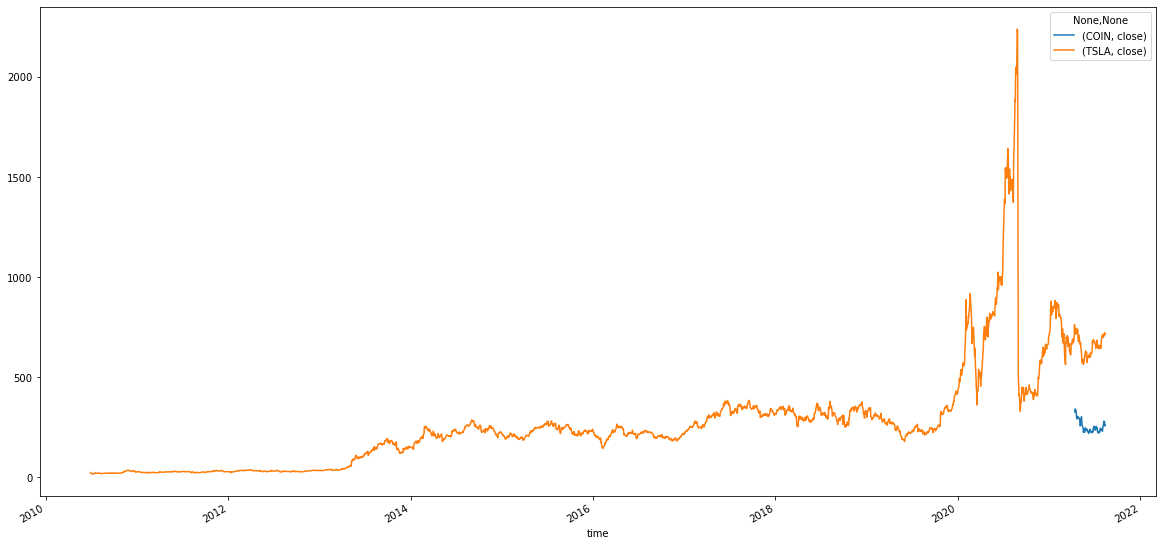

In [6]:
all_close_df = all_results_df.xs('close', axis=1, level=1, drop_level=False)
all_close_df.plot(figsize=[20, 10])